<h2>Tokenizing Wearable Accelerometer Data, Setup



In [1]:
#libraries

import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import manifold
from sklearn import metrics
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import urllib.request
import shutil
import zipfile
import utils

pd.options.display.max_rows = 999
pd.options.display.max_colwidth = None

# For reproducibility
np.random.seed(42)
N_JOBS = 2


/Users/kyraedwards/Documents/Oxford/DPhil/Rotation_Wearables/Tokenizer/Wearable_Tokenizer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read data

In [2]:
print(f"Downloading Capture-24...")

url = "https://ora.ox.ac.uk/objects/uuid:99d7c092-d865-4a19-b096-cc16440cd001/download_file?file_format=&safe_filename=capture24.zip&type_of_work=Dataset"
with urllib.request.urlopen(url) as f_src, open("capture24.zip", "wb") as f_dst:
     shutil.copyfileobj(f_src, f_dst)
print("Unzipping...")
with zipfile.ZipFile("capture24.zip", "r") as f:
     f.extractall(".")


Unzipping...


In [3]:
print(f'Content of capture24/')
print(os.listdir("capture24/"))

data = utils.load_data('capture24/P001.csv.gz')
print('\nParticipant P001:')
print(data)

Content of capture24/
['P147.csv.gz', 'P047.csv.gz', 'P059.csv.gz', 'P124.csv.gz', 'P024.csv.gz', 'P055.csv.gz', 'P028.csv.gz', 'P128.csv.gz', 'P036.csv.gz', 'P136.csv.gz', 'P063.csv.gz', 'P100.csv.gz', 'P071.csv.gz', 'annotation-label-dictionary.csv', 'P112.csv.gz', 'P012.csv.gz', 'P082.csv.gz', 'P090.csv.gz', '.DS_Store', 'P092.csv.gz', 'P080.csv.gz', 'P049.csv.gz', 'P149.csv.gz', 'P034.csv.gz', 'P134.csv.gz', 'P057.csv.gz', 'P126.csv.gz', 'P026.csv.gz', 'P145.csv.gz', 'P045.csv.gz', 'P138.csv.gz', 'P038.csv.gz', 'P110.csv.gz', 'P010.csv.gz', 'P073.csv.gz', 'P002.csv.gz', 'P102.csv.gz', 'P061.csv.gz', 'P084.csv.gz', 'P096.csv.gz', 'P088.csv.gz', 'P006.csv.gz', 'P106.csv.gz', 'P018.csv.gz', 'P118.csv.gz', 'P065.csv.gz', 'P114.csv.gz', 'P014.csv.gz', 'P069.csv.gz', 'P077.csv.gz', 'P122.csv.gz', 'P022.csv.gz', 'P141.csv.gz', 'P041.csv.gz', 'P030.csv.gz', 'P130.csv.gz', 'P053.csv.gz', 'P108.csv.gz', 'P008.csv.gz', 'P075.csv.gz', 'P116.csv.gz', 'P016.csv.gz', 'P067.csv.gz', 'P004.csv.gz',

*Look/Check at Data (Participant 1)*

In [4]:
X, Y, T = utils.make_windows(data, winsec=1) #1 second windows. 

In [5]:
print(T)

['2016-11-13T02:18:00.000000000' '2016-11-13T02:18:01.000000000'
 '2016-11-13T02:18:02.000000000' ... '2016-11-14T06:07:57.000000000'
 '2016-11-14T06:07:58.000000000' '2016-11-14T06:07:59.000000000']


In [6]:
X

array([[[-0.46669036, -0.5333412 ,  0.65847206],
        [-0.46669036, -0.5333412 ,  0.65847206],
        [-0.46669036, -0.5333412 ,  0.65847206],
        ...,
        [-0.46669036, -0.54890245,  0.65847206],
        [-0.46669036, -0.5333412 ,  0.6430769 ],
        [-0.46669036, -0.5333412 ,  0.6430769 ]],

       [[-0.46669036, -0.5333412 ,  0.65847206],
        [-0.46669036, -0.54890245,  0.65847206],
        [-0.46669036, -0.54890245,  0.6430769 ],
        ...,
        [-0.46669036, -0.54890245,  0.65847206],
        [-0.46669036, -0.5333412 ,  0.65847206],
        [-0.46669036, -0.5333412 ,  0.65847206]],

       [[-0.46669036, -0.54890245,  0.6430769 ],
        [-0.46669036, -0.54890245,  0.65847206],
        [-0.46669036, -0.5333412 ,  0.65847206],
        ...,
        [-0.46669036, -0.5333412 ,  0.65847206],
        [-0.46669036, -0.5333412 ,  0.65847206],
        [-0.46669036, -0.5333412 ,  0.65847206]],

       ...,

       [[ 0.0494156 , -0.7978458 ,  0.56569976],
        [ 0

In [7]:
Y

array(['7030 sleeping;MET 0.95', '7030 sleeping;MET 0.95',
       '7030 sleeping;MET 0.95', ..., '7030 sleeping;MET 0.95',
       '7030 sleeping;MET 0.95', '7030 sleeping;MET 0.95'],
      shape=(74695,), dtype='<U191')

In [8]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("T shape:", T.shape)

X shape: (74695, 100, 3)
Y shape: (74695,)
T shape: (74695,)


convert annotations to labels 

In [9]:
anno_label_dict = pd.read_csv(
    "capture24/annotation-label-dictionary.csv",
    index_col='annotation', 
    dtype='string'
)

# Map annotations using Willetts' labels  (see paper reference at the bottom)
Y = anno_label_dict.loc[Y, 'label:Willetts2018'].to_numpy()

In [10]:
print(X.shape)

(74695, 100, 3)


In [11]:
print(Y.shape)

(74695,)


<h2> Tokenizer


1. `Normalization` 
2. `Quantization (binning)`
3. `Apply BPE`

<h3> Normalization


<h5>Exploratory analysis of distribution of magnitudes, overall, categories and compression options 

*All Participants*

In [11]:
all_M = []
all_Y = []
all_T = []

# Get a list of all magnitudes to understand the distribution of the data.
for i in os.listdir("capture24/"):

    if i.startswith("P") and i.endswith(".csv.gz"):

        data = utils.load_data(f'capture24/{i}')  # Use the current file name
        X, Y, T = utils.make_windows(data, winsec=1)  # 1-second windows
        M = np.linalg.norm(X, axis=2)
        

        all_M.append(M)
        all_Y.append(Y)
        all_T.append(T)
        print(i)

P147.csv.gz
P047.csv.gz
P059.csv.gz
P124.csv.gz
P024.csv.gz
P055.csv.gz
P028.csv.gz
P128.csv.gz
P036.csv.gz
P136.csv.gz
P063.csv.gz
P100.csv.gz
P071.csv.gz
P112.csv.gz
P012.csv.gz
P082.csv.gz
P090.csv.gz
P092.csv.gz
P080.csv.gz
P049.csv.gz
P149.csv.gz
P034.csv.gz
P134.csv.gz
P057.csv.gz
P126.csv.gz
P026.csv.gz
P145.csv.gz
P045.csv.gz
P138.csv.gz
P038.csv.gz
P110.csv.gz
P010.csv.gz
P073.csv.gz
P002.csv.gz
P102.csv.gz
P061.csv.gz
P084.csv.gz
P096.csv.gz
P088.csv.gz
P006.csv.gz
P106.csv.gz
P018.csv.gz
P118.csv.gz
P065.csv.gz
P114.csv.gz
P014.csv.gz
P069.csv.gz
P077.csv.gz
P122.csv.gz
P022.csv.gz
P141.csv.gz
P041.csv.gz
P030.csv.gz
P130.csv.gz
P053.csv.gz
P108.csv.gz
P008.csv.gz
P075.csv.gz
P116.csv.gz
P016.csv.gz
P067.csv.gz
P004.csv.gz
P104.csv.gz
P079.csv.gz
P051.csv.gz
P151.csv.gz
P032.csv.gz
P132.csv.gz
P143.csv.gz
P043.csv.gz
P120.csv.gz
P020.csv.gz
P094.csv.gz
P098.csv.gz
P086.csv.gz
P083.csv.gz
P091.csv.gz
P101.csv.gz
P001.csv.gz
P062.csv.gz
P013.csv.gz
P113.csv.gz
P070.csv.gz
P025

In [12]:
# Flatten and concatenate all elements in all_M into a single 1D array
collapsed_M = np.concatenate([m.flatten() if isinstance(m, np.ndarray) else np.array(m).flatten() for m in all_M])

print(collapsed_M.shape)  # Print the shape of the resulting array

(921746400,)


In [13]:
# Create a DataFrame from the flattened array
df = pd.DataFrame(collapsed_M, columns=['Magnitude'])
# Save the DataFrame to a CSV file
df.to_csv('capture24_magnitude_flat.csv', index=False)

In [14]:
# Convert all_Y to a flattened list or array
all_Y_flat = np.concatenate([m.flatten() if isinstance(m, np.ndarray) else np.array(m).flatten() for m in all_Y])
all_Ys = anno_label_dict.loc[all_Y_flat, 'label:Willetts2018'].to_numpy()
print(all_Ys.shape)  # Print the shape of the resulting array

(9217464,)


In [15]:
all_T_flat = np.concatenate([m.flatten() if isinstance(m, np.ndarray) else np.array(m).flatten() for m in all_T])
print(all_T_flat.shape)

(9217464,)


In [17]:
# Create a DataFrame with the flattened magnitudes and corresponding labels and timestamps
df = pd.DataFrame({
    'label': all_Ys,
    'timestamp': all_T_flat
})
# Save the DataFrame to a CSV file
df.to_csv('capture24_all_labels_times.csv', index=False)

In [18]:
def get_most_frequent_bin(data, bins=100):

    # Compute the histogram
    counts, bin_edges = np.histogram(data, bins=bins)

    # Find the index of the most frequent bin
    most_frequent_bin_index = np.argmax(counts)

    # Get the boundaries of the most frequent bin
    lower_bound = bin_edges[most_frequent_bin_index]
    upper_bound = bin_edges[most_frequent_bin_index + 1]

    return lower_bound, upper_bound


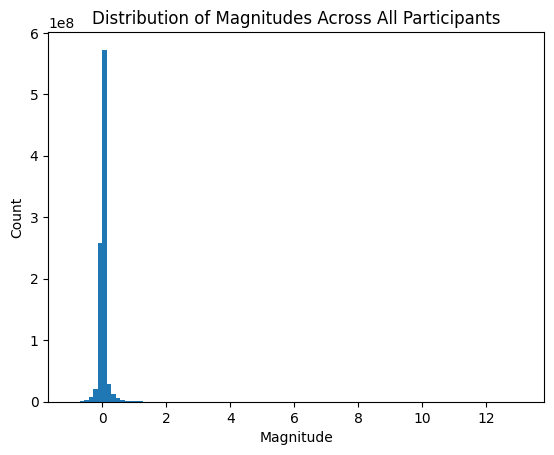

The most frequent bin is between -0.01 and 0.13


In [19]:
plt.hist(collapsed_M-1, bins=100)
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.title("Distribution of Magnitudes Across All Participants")
plt.show()


lower, upper = get_most_frequent_bin((collapsed_M-1), bins=100)
print(f"The most frequent bin is between {lower:.2f} and {upper:.2f}")

Gravity adjustment : -1

In [20]:
all_M_norm = collapsed_M - 1

In [22]:
# Function to calculate and print summary statistics
def calculate_statistics(data):
    """
    Calculate and print various summary statistics for a given dataset.

    Parameters:
        data (numpy.ndarray): The input data array.
    """
    # Calculate statistics
    range_data = np.max(data) - np.min(data)
    q1 = np.percentile(data, 25)  # 25th percentile
    q3 = np.percentile(data, 75)  # 75th percentile
    iqr_data = q3 - q1
    mean_data = np.mean(data)
    std_data = np.std(data)
    ci1 = mean_data - (std_data * 2)
    ci2 = mean_data + (std_data * 2)

    # Print results
    print(f"Minimum Magnitude: {np.min(data)}")
    print(f"Maximum Magnitude: {np.max(data)}")
    print(f"Mean Magnitude: {mean_data}")
    print(f"Standard Deviation: {std_data}")
    print(f"Median Magnitude: {np.median(data)}")
    print(f"Range: {range_data}")
    print(f"IQR: {iqr_data}")
    print(f"95% Confidence Interval: ({ci1}, {ci2})")


All Magnitude Stats

In [ ]:
calculate_statistics(all_M_norm)

Minimum Magnitude: -0.9939326643943787
Maximum Magnitude: 13.105237007141113
Mean Magnitude: 0.012739930301904678
Standard Deviation: 0.1547142118215561


note: normally distributed

<h3> Break down by Labels

In [133]:
labs=np.unique(all_Ys)
sitting=labs[2]
sleeping=labs[3]
biking=labs[0]
walking=labs[5]

In [134]:
sit_indx= np.where(all_Ys == sitting)
sleep_indx= np.where(all_Ys == sleeping)
bike_indx= np.where(all_Ys == biking)
walk_indx= np.where(all_Ys == walking)

Sitting Magnitude Distribution

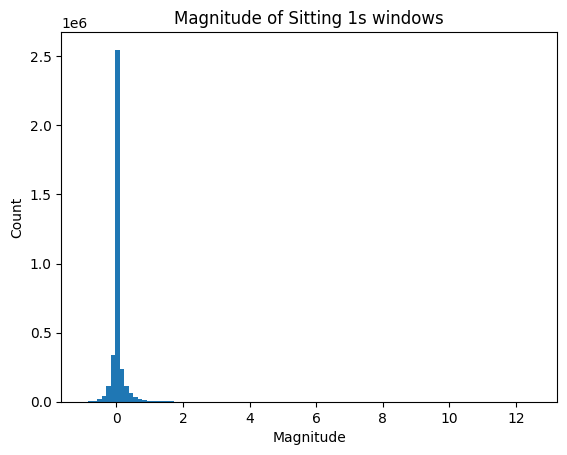

In [ ]:
plt.hist(all_M_norm[sit_indx], bins=100)
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.title("Magnitude of Sitting 1s windows")
plt.show()



In [171]:

print("Sitting \n")
calculate_statistics(all_M_norm[sit_indx])

lower, upper = get_most_frequent_bin(all_M_norm[sit_indx], bins=100)
print(f"The most frequent bin is between {lower:.2f} and {upper:.2f}")

Sitting 

Minimum Magnitude: -0.9812279939651489
Maximum Magnitude: 12.566415786743164
Mean Magnitude: 0.04418662562966347
Standard Deviation: 0.28932425379753113
Median Magnitude: 0.0016883611679077148
Range: 13.547643661499023
IQR: 0.02748677134513855
95% Confidence Interval: (-0.5344618558883667, 0.6228351593017578)
The most frequent bin is between -0.03 and 0.10


Sleeping Magnitude Distribution

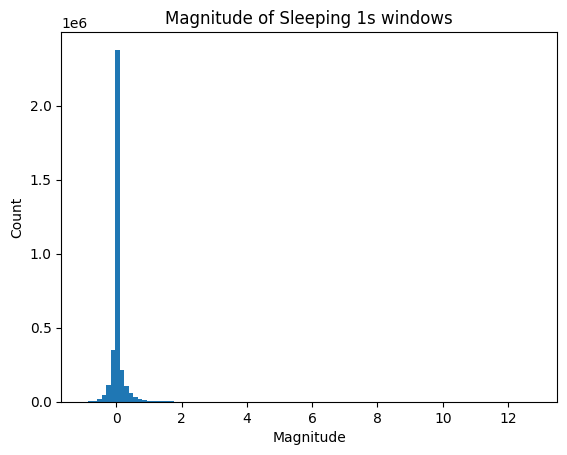

The most frequent bin is between -0.03 and 0.11


In [ ]:
plt.hist(all_M_norm[sleep_indx], bins=100)
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.title("Magnitude of Sleeping 1s windows")
plt.show()

In [170]:
print("Sleeping \n")

calculate_statistics(all_M_norm[sleep_indx])

lower, upper = get_most_frequent_bin(all_M_norm[sleep_indx], bins=100)
print(f"The most frequent bin is between {lower:.2f} and {upper:.2f}")

Sleeping 

Minimum Magnitude: -0.9919753670692444
Maximum Magnitude: 12.81689739227295
Mean Magnitude: 0.04631979018449783
Standard Deviation: 0.28617605566978455
Median Magnitude: 0.0023605823516845703
Range: 13.808873176574707
IQR: 0.026350557804107666
95% Confidence Interval: (-0.5260323286056519, 0.6186718940734863)
The most frequent bin is between -0.03 and 0.11


In [123]:
from scipy.stats import ttest_ind

# Perform the t-test
t_stat, p_value = ttest_ind(all_M_norm[sleep_indx], all_M_norm[sit_indx], equal_var=False)

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The difference between the two groups is statistically significant.")
else:
    print("The difference between the two groups is not statistically significant.")

T-statistic: 9.801979211253926
P-value: 1.1043812537018166e-22
The difference between the two groups is statistically significant.


Biking Magnitude Distribution

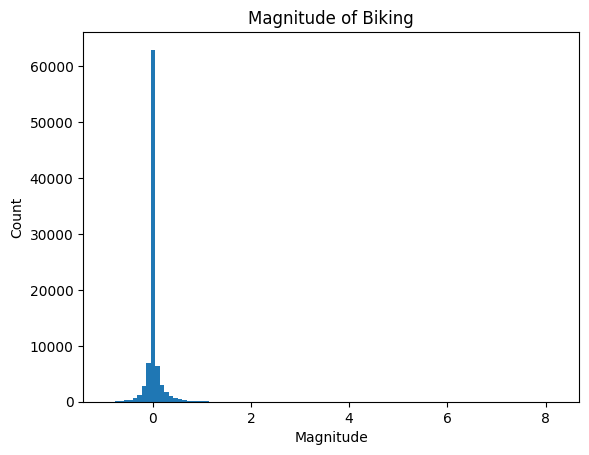

Minimum Magnitude: -0.9556892514228821
Maximum Magnitude: 8.223369598388672
Mean Magnitude: 0.021442564204335213
Standard Deviation: 0.1931241750717163
Median Magnitude: 0.0015652179718017578
Range: 9.179059028625488
IQR: 0.02160048484802246
95% Confidence Interval: (-0.36480578780174255, 0.4076909124851227)
The most frequent bin is between -0.04 and 0.05


In [ ]:
plt.hist(all_M_norm[bike_indx], bins=100)
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.title("Magnitude of Biking")
plt.show()

print("Biking \n")

calculate_statistics(all_M_norm[bike_indx])
lower, upper = get_most_frequent_bin(all_M_norm[bike_indx], bins=100)
print(f"The most frequent bin is between {lower:.2f} and {upper:.2f}")

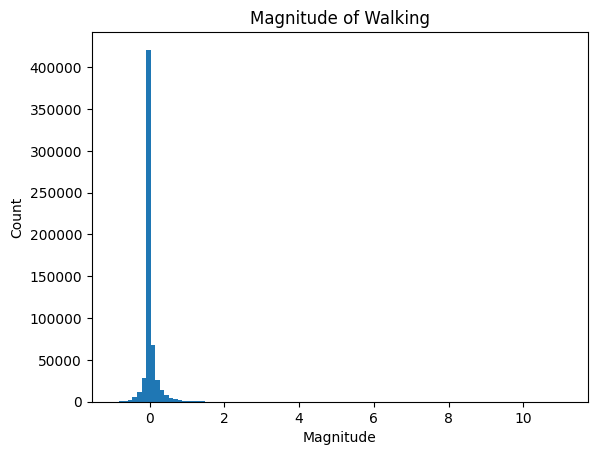

Walking 

Minimum Magnitude: -0.9405786395072937
Maximum Magnitude: 11.12188720703125
Mean Magnitude: 0.03360254317522049
Standard Deviation: 0.24539917707443237
Median Magnitude: 0.0018000602722167969
Range: 12.06246566772461
IQR: 0.022200465202331543
95% Confidence Interval: (-0.45719581842422485, 0.5244008898735046)
The most frequent bin is between -0.10 and 0.02


In [168]:
plt.hist(all_M_norm[walk_indx], bins=100)
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.title("Magnitude of Walking")
plt.show()


print("Walking \n")
calculate_statistics(all_M_norm[walk_indx])
lower, upper = get_most_frequent_bin(all_M_norm[walk_indx], bins=100)
print(f"The most frequent bin is between {lower:.2f} and {upper:.2f}")

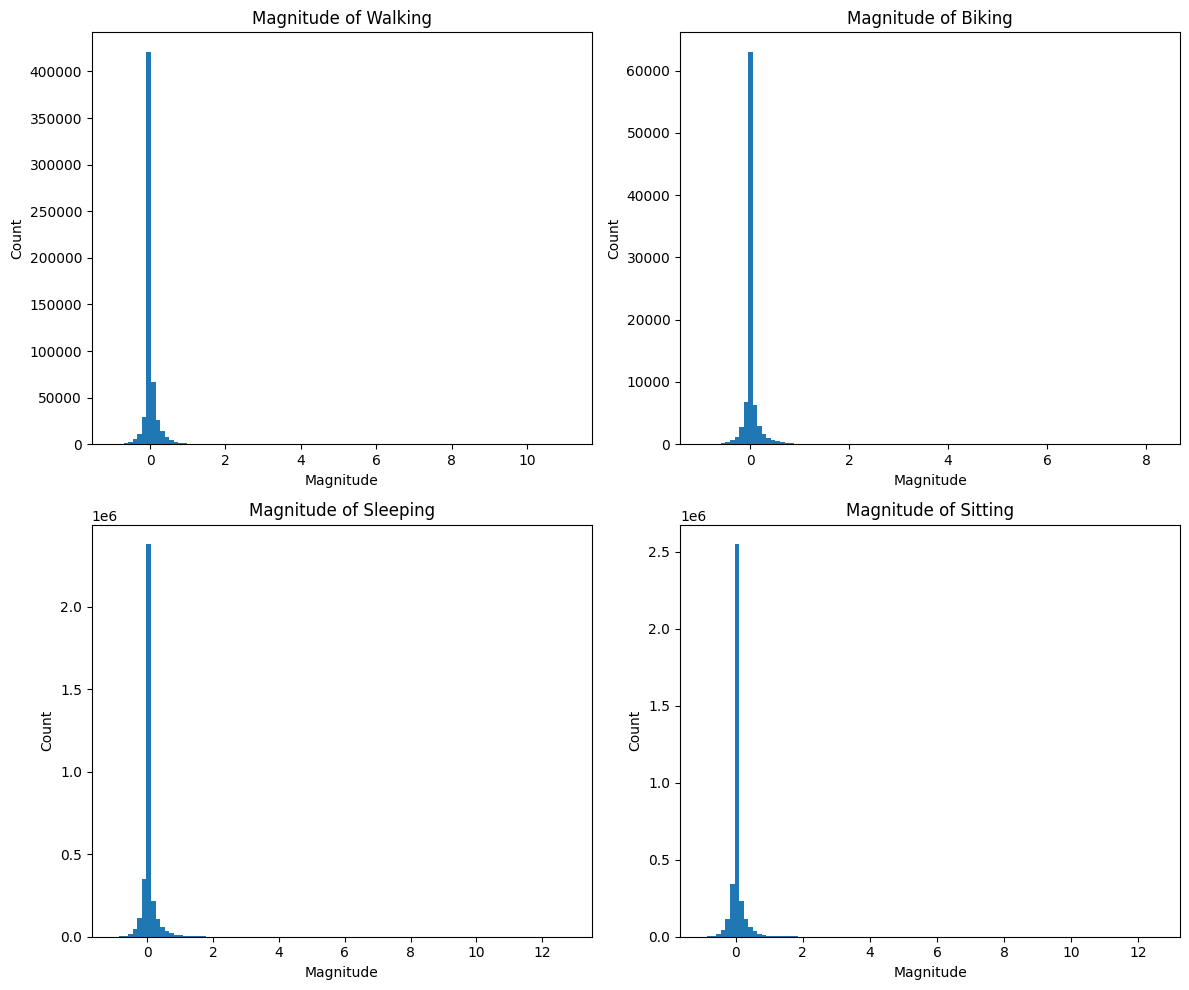

In [ ]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Plot for walking
axes[0, 0].hist(all_M_norm[walk_indx], bins=100)
axes[0, 0].set_xlabel("Magnitude")
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_title("Magnitude of Walking")

# Plot for biking
axes[0, 1].hist(all_M_norm[bike_indx], bins=100)
axes[0, 1].set_xlabel("Magnitude")
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_title("Magnitude of Biking")

# Plot for sleeping
axes[1, 0].hist(all_M_norm[sleep_indx], bins=100)
axes[1, 0].set_xlabel("Magnitude")
axes[1, 0].set_ylabel("Count")
axes[1, 0].set_title("Magnitude of Sleeping")

# Plot for sitting
axes[1, 1].hist(all_M_norm[sit_indx], bins=100)
axes[1, 1].set_xlabel("Magnitude")
axes[1, 1].set_ylabel("Count")
axes[1, 1].set_title("Magnitude of Sitting")

# Adjust layout
plt.tight_layout()
plt.show()

Rest vs Active Magnitude 

In [ ]:
# Flatten both arrays and then concatenate
# Convert tuples to NumPy arrays
sit_indx_array = np.array(sit_indx)
sleep_indx_array = np.array(sleep_indx)

# Flatten both arrays and then concatenate
rest_indx = np.concatenate([sit_indx_array.ravel(), sleep_indx_array.ravel()])



[  18345   18346   18347 ... 9217461 9217462 9217463]


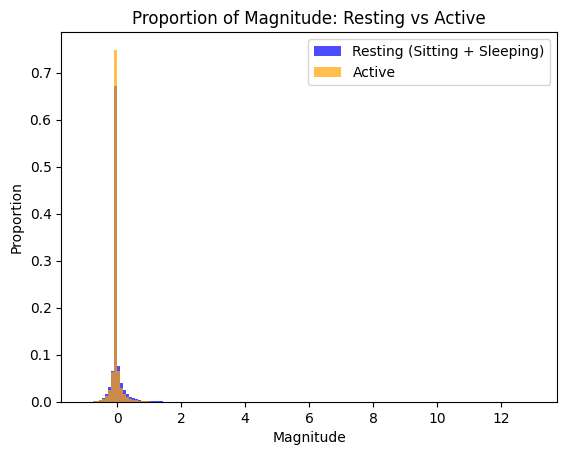

The most frequent bin for resting is between -0.05 and 0.05
The most frequent bin for active is between -0.05 and 0.05


In [196]:
# Define common bin boundaries
common_bins = np.linspace(min(all_M_norm.min(), all_M_norm[rest_indx].min(), all_M_norm[~rest_indx].min()),
                          max(all_M_norm.max(), all_M_norm[rest_indx].max(), all_M_norm[~rest_indx].max()), 150)

# Compute histograms with the same bins
counts_rest, _ = np.histogram(all_M_norm[rest_indx], bins=common_bins, density=False)
counts_active, _ = np.histogram(all_M_norm[~rest_indx], bins=common_bins, density=False)

# Normalize to proportions
counts_rest = counts_rest / counts_rest.sum()
counts_active = counts_active / counts_active.sum()

# Plot histograms
plt.bar(common_bins[:-1], counts_rest, width=(common_bins[1] - common_bins[0]), alpha=0.7, color='blue', label="Resting (Sitting + Sleeping)")
plt.bar(common_bins[:-1], counts_active, width=(common_bins[1] - common_bins[0]), alpha=0.7, color='orange', label="Active")
plt.xlabel("Magnitude")
plt.ylabel("Proportion")
plt.title("Proportion of Magnitude: Resting vs Active")
plt.legend()
plt.show()

# Get the most frequent bin for resting
lower, upper = get_most_frequent_bin(all_M_norm[rest_indx], bins=common_bins)
print(f"The most frequent bin for resting is between {lower:.2f} and {upper:.2f}")

# Get the most frequent bin for active
lower, upper = get_most_frequent_bin(all_M_norm[~rest_indx], bins=common_bins)
print(f"The most frequent bin for active is between {lower:.2f} and {upper:.2f}")

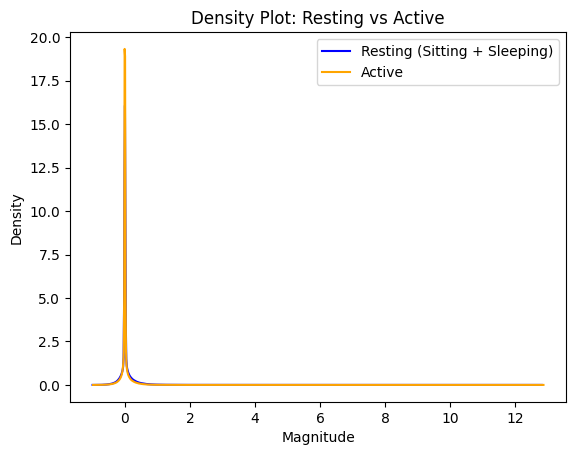

In [ ]:
from scipy.stats import gaussian_kde

# Calculate density for resting group
density_rest = gaussian_kde(all_M_norm[rest_indx])
x_rest = np.linspace(min(all_M_norm[rest_indx]), max(all_M_norm[rest_indx]), 1000)
y_rest = density_rest(x_rest)

# Calculate density for active group
density_active = gaussian_kde(all_M_norm[~rest_indx])
x_active = np.linspace(min(all_M_norm[~rest_indx]), max(all_M_norm[~rest_indx]), 1000)
y_active = density_active(x_active)

# Plot the density lines
plt.plot(x_rest, y_rest, label="Resting (Sitting + Sleeping)", color='blue')
plt.plot(x_active, y_active, label="Active", color='orange')
plt.xlabel("Magnitude")
plt.ylabel("Density")
plt.title("Density Plot: Resting vs Active")
plt.legend()
plt.show()

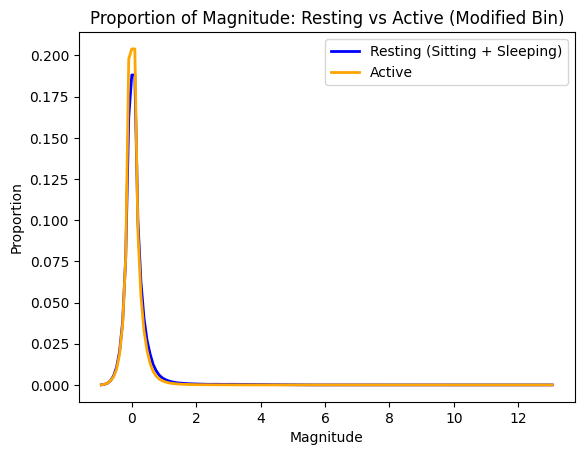

In [202]:
import numpy as np
import matplotlib.pyplot as plt

# Define common bin boundaries
common_bins = np.linspace(min(all_M_norm.min(), all_M_norm[rest_indx].min(), all_M_norm[~rest_indx].min()),
                          max(all_M_norm.max(), all_M_norm[rest_indx].max(), all_M_norm[~rest_indx].max()), 150)

# Compute histograms with the same bins
counts_rest, _ = np.histogram(all_M_norm[rest_indx], bins=common_bins, density=False)
counts_active, _ = np.histogram(all_M_norm[~rest_indx], bins=common_bins, density=False)

# Find the bin index for the range -0.05 to 0.05
bin_index = np.where((common_bins[:-1] >= -0.05) & (common_bins[1:] <= 0.05))[0]

if len(bin_index) > 0:
    bin_index = bin_index[0]  # Get the first matching bin index

    # Replace the bin count with the value of the next bin
    counts_rest[bin_index] = counts_rest[bin_index + 1]
    counts_active[bin_index] = counts_active[bin_index + 1]

# Normalize to proportions
counts_rest = counts_rest / counts_rest.sum()
counts_active = counts_active / counts_active.sum()

# Compute bin centers for plotting
bin_centers = (common_bins[:-1] + common_bins[1:]) / 2

# Plot line plots
plt.plot(bin_centers, counts_rest, label="Resting (Sitting + Sleeping)", color='blue', linewidth=2)
plt.plot(bin_centers, counts_active, label="Active", color='orange', linewidth=2)
plt.xlabel("Magnitude")
plt.ylabel("Proportion")
plt.title("Proportion of Magnitude: Resting vs Active (Modified Bin)")
plt.legend()
plt.show()

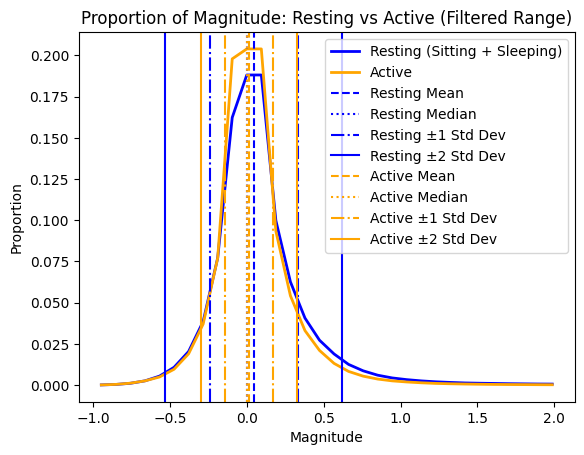

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define common bin boundaries
common_bins = np.linspace(min(all_M_norm.min(), all_M_norm[rest_indx].min(), all_M_norm[~rest_indx].min()),
                          max(all_M_norm.max(), all_M_norm[rest_indx].max(), all_M_norm[~rest_indx].max()), 150)

# Compute histograms with the same bins
counts_rest, _ = np.histogram(all_M_norm[rest_indx], bins=common_bins, density=False)
counts_active, _ = np.histogram(all_M_norm[~rest_indx], bins=common_bins, density=False)

# Find the bin index for the range -0.05 to 0.05
bin_index = np.where((common_bins[:-1] >= -0.05) & (common_bins[1:] <= 0.05))[0]

if len(bin_index) > 0:
    bin_index = bin_index[0]  # Get the first matching bin index

    # Replace the bin count with the value of the next bin
    counts_rest[bin_index] = counts_rest[bin_index + 1]
    counts_active[bin_index] = counts_active[bin_index + 1]

# Normalize to proportions
counts_rest = counts_rest / counts_rest.sum()
counts_active = counts_active / counts_active.sum()

# Compute bin centers for plotting
bin_centers = (common_bins[:-1] + common_bins[1:]) / 2

# Filter values between -1 and 2
mask = (bin_centers >= -1) & (bin_centers <= 2)
filtered_bin_centers = bin_centers[mask]
filtered_counts_rest = counts_rest[mask]
filtered_counts_active = counts_active[mask]

# Calculate statistics for resting
mean_rest = np.mean(all_M_norm[rest_indx])
median_rest = np.median(all_M_norm[rest_indx])
std_rest = np.std(all_M_norm[rest_indx])

# Calculate statistics for active
mean_active = np.mean(all_M_norm[~rest_indx])
median_active = np.median(all_M_norm[~rest_indx])
std_active = np.std(all_M_norm[~rest_indx])

# Plot line plots for the filtered range
plt.plot(filtered_bin_centers, filtered_counts_rest, label="Resting (Sitting + Sleeping)", color='blue', linewidth=2)
plt.plot(filtered_bin_centers, filtered_counts_active, label="Active", color='orange', linewidth=2)

# Add vertical lines for resting statistics
plt.axvline(mean_rest, color='blue', linestyle='--', label="Resting Mean")
plt.axvline(median_rest, color='blue', linestyle=':', label="Resting Median")
plt.axvline(mean_rest - std_rest, color='blue', linestyle='-.', label="Resting ±1 Std Dev")
plt.axvline(mean_rest + std_rest, color='blue', linestyle='-.')
plt.axvline(mean_rest - 2 * std_rest, color='blue', linestyle='-', label="Resting ±2 Std Dev")
plt.axvline(mean_rest + 2 * std_rest, color='blue', linestyle='-')

# Add vertical lines for active statistics
plt.axvline(mean_active, color='orange', linestyle='--', label="Active Mean")
plt.axvline(median_active, color='orange', linestyle=':', label="Active Median")
plt.axvline(mean_active - std_active, color='orange', linestyle='-.', label="Active ±1 Std Dev")
plt.axvline(mean_active + std_active, color='orange', linestyle='-.')
plt.axvline(mean_active - 2 * std_active, color='orange', linestyle='-', label="Active ±2 Std Dev")
plt.axvline(mean_active + 2 * std_active, color='orange', linestyle='-')

# Add labels, title, and legend
plt.xlabel("Magnitude")
plt.ylabel("Proportion")
plt.title("Proportion of Magnitude: Resting vs Active (Filtered Range)")
plt.legend()
plt.show()

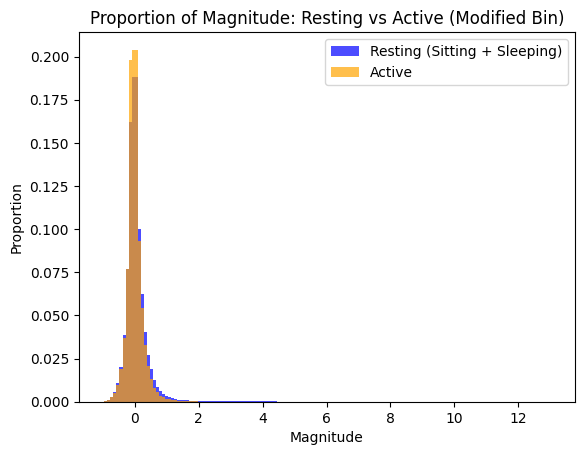

In [200]:
# Define common bin boundaries
common_bins = np.linspace(min(all_M_norm.min(), all_M_norm[rest_indx].min(), all_M_norm[~rest_indx].min()),
                          max(all_M_norm.max(), all_M_norm[rest_indx].max(), all_M_norm[~rest_indx].max()), 150)

# Compute histograms with the same bins
counts_rest, _ = np.histogram(all_M_norm[rest_indx], bins=common_bins, density=False)
counts_active, _ = np.histogram(all_M_norm[~rest_indx], bins=common_bins, density=False)

# Find the bin index for the range -0.05 to 0.05
bin_index = np.where((common_bins[:-1] >= -0.05) & (common_bins[1:] <= 0.05))[0]

if len(bin_index) > 0:
    bin_index = bin_index[0]  # Get the first matching bin index

    # Replace the bin count with the value of the next bin
    counts_rest[bin_index] = counts_rest[bin_index + 1]
    counts_active[bin_index] = counts_active[bin_index + 1]

# Normalize to proportions
counts_rest = counts_rest / counts_rest.sum()
counts_active = counts_active / counts_active.sum()

# Plot histograms
plt.bar(common_bins[:-1], counts_rest, width=(common_bins[1] - common_bins[0]), alpha=0.7, color='blue', label="Resting (Sitting + Sleeping)")
plt.bar(common_bins[:-1], counts_active, width=(common_bins[1] - common_bins[0]), alpha=0.7, color='orange', label="Active")
plt.xlabel("Magnitude")
plt.ylabel("Proportion")
plt.title("Proportion of Magnitude: Resting vs Active (Modified Bin)")
plt.legend()
plt.show()

In [193]:
# Perform the t-test
t_stat, p_value = ttest_ind(all_M_norm[rest_indx], all_M_norm[~rest_indx], equal_var=False)

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The difference between the two groups is statistically significant.")
else:
    print("The difference between the two groups is not statistically significant.")

T-statistic: 238.04533795580093
P-value: 0.0
The difference between the two groups is statistically significant.


In [203]:
print("Rest: \n")
calculate_statistics(all_M_norm[rest_indx])
print("Active: \n")
calculate_statistics(all_M_norm[~rest_indx])

Rest: 

Minimum Magnitude: -0.9919753670692444
Maximum Magnitude: 12.81689739227295
Mean Magnitude: 0.04522349312901497
Standard Deviation: 0.28780025243759155
Median Magnitude: 0.0020862817764282227
Range: 13.808873176574707
IQR: 0.026886284351348877
95% Confidence Interval: (-0.5303770303726196, 0.6208239793777466)
Active: 

Minimum Magnitude: -0.9766895771026611
Maximum Magnitude: 12.868141174316406
Mean Magnitude: 0.015775630250573158
Standard Deviation: 0.15570177137851715
Median Magnitude: 0.0009828805923461914
Range: 13.844830513000488
IQR: 0.021319448947906494
95% Confidence Interval: (-0.2956279218196869, 0.3271791636943817)


In [210]:
print('rest', 0.04522349312901497+ 0.981)

print("active", 0.015775630250573158 + 0.981)

rest 1.0262234931290148
active 0.9967756302505731


<h3>Quantization

<h3> Cut points for quanitisation


- `Arbitrary`
- `Distribution Driven`

<h4> Naive cut points (baseline)

In [213]:
# Calculate the minimum and maximum of all_M_norm
min_val = np.min(all_M_norm)
max_val = np.max(all_M_norm)

# Divide the range into 20 equal parts
arbitrary_cuts = np.linspace(min_val, max_val, 21)  # 21 points create 20 equal intervals

print("Arbitrary cuts (range divided into 20 equal parts):")
print(arbitrary_cuts)

Arbitrary cuts (range divided into 20 equal parts):
[-0.99393266 -0.28897417  0.41598433  1.1209428   1.8259013   2.5308597
  3.2358184   3.9407768   4.6457353   5.3506937   6.055652    6.7606106
  7.4655695   8.170527    8.875486    9.580444   10.285403   10.990362
 11.69532    12.400279   13.105237  ]


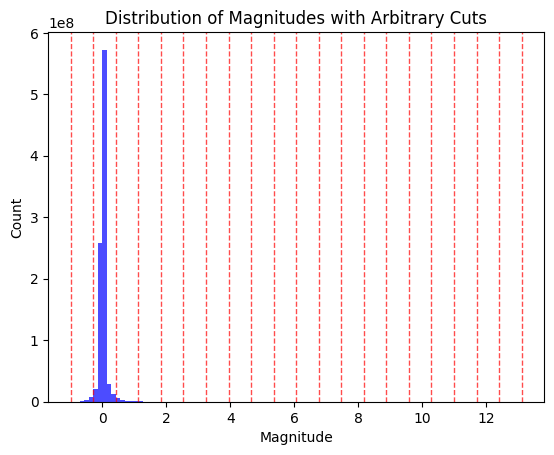

In [216]:
# Calculate the minimum and maximum of all_M_norm
min_val = np.min(all_M_norm)
max_val = np.max(all_M_norm)

# Divide the range into 20 equal parts
arbitrary_cuts = np.linspace(min_val, max_val, 21)  # 21 points create 20 equal intervals

# Plot the histogram
plt.hist(all_M_norm, bins=100, alpha=0.7, color='blue')
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.title("Distribution of Magnitudes with Arbitrary Cuts")

# Add vertical lines for the arbitrary cuts
for cut in arbitrary_cuts:
    plt.axvline(cut, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.show()

<h4>Data Distribution driven

1. Based on mass of distribution- more cut points inside 95% confidence interval, more spare outside of this interval

- `Evenly distributed across confidence interval`
- `Cuts particularly include mean, median, + - 1, 2 sds`


80% of the cut points within the 95% confidence interval

In [ ]:
# Calculate the mean and standard deviation of all_M_norm
mean_all_M_norm = np.mean(all_M_norm)
std_all_M_norm = np.std(all_M_norm)

# Calculate the 95% confidence interval
ci_lower = mean_all_M_norm - 1.96 * std_all_M_norm
ci_upper = mean_all_M_norm + 1.96 * std_all_M_norm

# Divide the confidence interval into 16 equal parts
ci_cuts = np.linspace(ci_lower, ci_upper, 17)  # 17 points create 16 intervals

# Divide the remaining range into 4 equal parts (2 on each side of the CI)
lower_range = np.linspace(np.min(all_M_norm), ci_lower, 3)[:-1]  # Exclude the upper bound to avoid overlap
upper_range = np.linspace(ci_upper, np.max(all_M_norm), 3)[1:]  # Exclude the lower bound to avoid overlap

# Combine all cut points into a single array
all_cut_points = np.concatenate([lower_range, ci_cuts, upper_range])

print("95% Confidence Interval:")
print(f"Lower: {ci_lower}, Upper: {ci_upper}")
print("\nAll 20 Cut Points:")
print(all_cut_points)

95% Confidence Interval:
Lower: -0.2904999256134033, Upper: 0.3159797787666321

All 20 Cut Points:
[-9.9393266e-01 -6.4221632e-01 -2.9049993e-01 -2.5259495e-01
 -2.1468997e-01 -1.7678498e-01 -1.3888000e-01 -1.0097502e-01
 -6.3070029e-02 -2.5165051e-02  1.2739927e-02  5.0644904e-02
  8.8549882e-02  1.2645486e-01  1.6435987e-01  2.0226485e-01
  2.4016982e-01  2.7807480e-01  3.1597978e-01  6.7106085e+00
  1.3105237e+01]


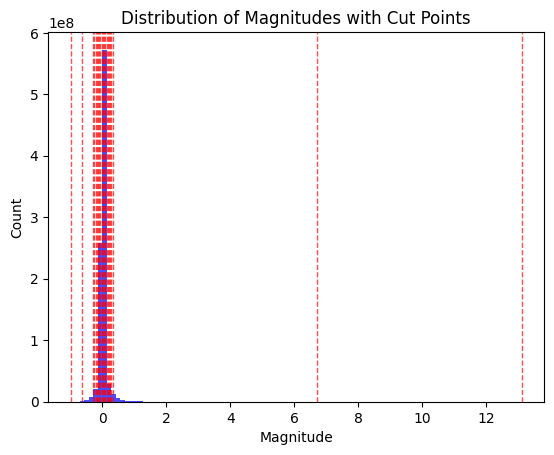

In [ ]:
# Plot the histogram of all_M_norm
plt.hist(all_M_norm, bins=100, alpha=0.7, color='blue')
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.title("Distribution of Magnitudes with Cut Points")

# Add vertical lines for the cut points
for cut in all_cut_points:
    plt.axvline(cut, color='red', linestyle='--', linewidth=1, alpha=0.7)

# Show the plot
plt.show()

<h3>Compresssion

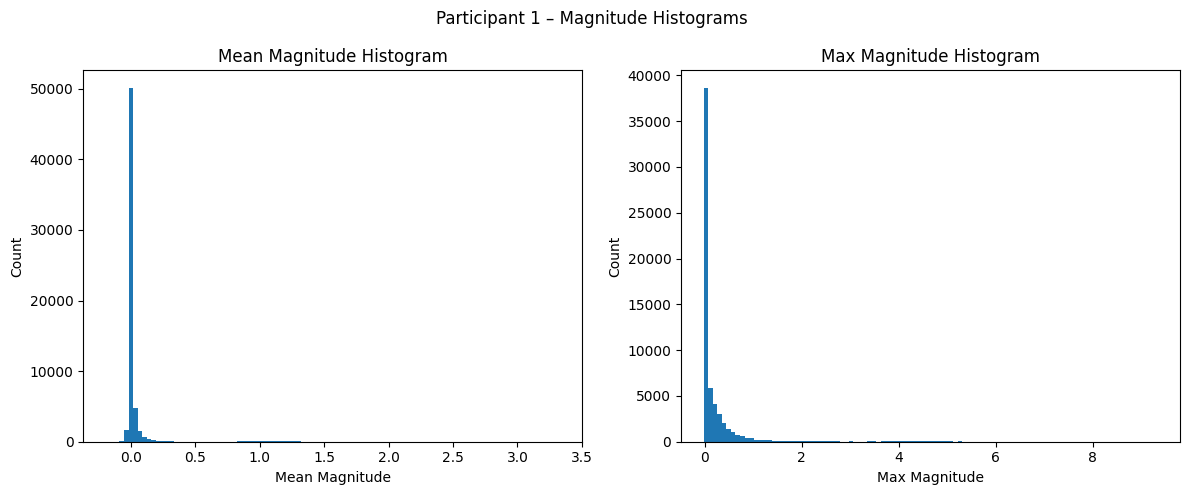

In [ ]:
M_mean = np.mean(all_M[1], axis=1)  # Find mean along the 2nd dimension (axis=1)

M_max=np.max(all_M[1], axis=1)  # Find max along the 2nd dimension (axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first histogram
axes[0].hist(M_mean-1, bins=100)
axes[0].set_xlabel("Mean Magnitude")
axes[0].set_ylabel("Count")
axes[0].set_title("Mean Magnitude Histogram")

# Plot the second histogram
axes[1].hist(M_max-1, bins=100)
axes[1].set_xlabel("Max Magnitude")
axes[1].set_ylabel("Count")
axes[1].set_title("Max Magnitude Histogram")

# Set a common subtitle
fig.suptitle("Participant 1 – Magnitude Histograms ")


plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

**Magnitude to String**

Establish cut points and labels.

Turn magnitude into string based on whether mean of each window passes through cut points. 

Helper functions:

- `assign lables`
- `labels to string`

*treats 0s as space*

**Deciding cut points**

1st cut- 2sd above (outside normal range) of sit/ stand. 

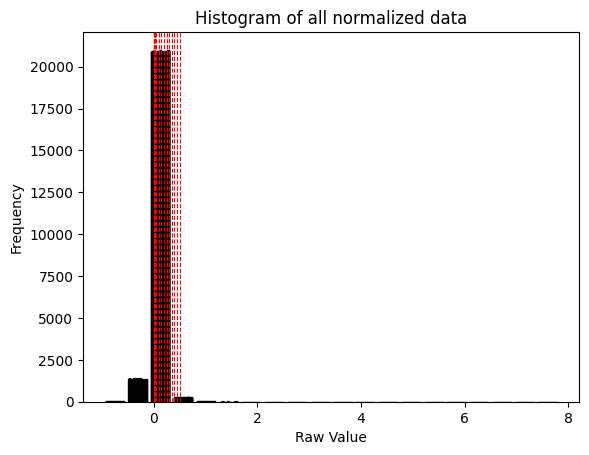

In [227]:
# Define the cut points
cuts = np.array([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])

# Plot the histogram
plt.hist(normalized_data, bins=20, edgecolor='black')  # Adjust bins as needed
plt.title('Histogram of all normalized data')
plt.xlabel('Raw Value')
plt.ylabel('Frequency')

# Add vertical lines at the cut points
for cut in cuts:
    plt.axvline(x=cut, color='red', linestyle='--', linewidth=0.8)

# Show the plot
plt.show()

summarize 

In [ ]:
import numpy as np

# Cuts and labels
cuts = np.array([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
labs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R']

# Function to assign the label corresponding to the highest absolute cut
def assign_label(max_values, cuts, labs):
    assigned_labels = []
    for value in max_values:
        # Find the cuts that the value passes through
        passed_cuts = cuts[np.abs(cuts) <= np.abs(value)]
        # Assign the label corresponding to the cut with the highest absolute value
        if len(passed_cuts) > 0:
            # Use np.isclose to find the index of the cut
            cut_index = np.where(np.isclose(cuts, passed_cuts[-1]))[0][0]
            assigned_labels.append(labs[cut_index])
        else:
            assigned_labels.append('A')  # Default to 'A' for 0
    return assigned_labels

# Assign labels to mean_values
assigned_labels = assign_label(mean_values, cuts, labs)
print(assigned_labels)

['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'D', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'F', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',

In [111]:
import re

# Convert assigned_labels into a single string with consecutive 'A's replaced by one space
def labels_to_string(assigned_labels):
    raw_string = ''.join(label if label != 'A' else ' ' for label in assigned_labels)
    return re.sub(r'\s+', ' ', raw_string).strip()  # Replace multiple spaces with one and strip leading/trailing spaces

# Example usage
result_string = labels_to_string(assigned_labels)
print(result_string)

BD FBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB B C BBBBBBBBBBBBBBBBBBBBBBBBE BBBBBBGBCCDDEEEEEEEEEFEFFFFFFFBEEDDDEEEEEEDDDDDBCCCCCCCCBBBBBBBBB CCB B IKJIIJHGIIIIIIIIIIIIHCCFFIBCIIJIIJIIII IIHJIDIIEEGHIFIIFIDIHDDDEBEEHHCDIDIFEIIIKLKKKIC IIHGBE GFDIDFJICC CDGJDHIIIIIEIIIIEICGCCBIKIJIIIIIJIJJJIIKIEIJEHCE B BCBBC IIIB EB B B B B IBEI CCCD BCBCBCBB CIBDDI JHEIGJJII BC CCBEIIICHELIMIGCEDEEIDFIIIIHFIIICBB D BCBBFCEBDCFIIIIIHIILLIIIIIIHFHFIIJIHHJIIG IJIGGIIDEDHHIBIIGFIHDCIIJIIIIIIIIIIJIIIIHCI CBC BBBBB B BBCBB BB B DB BBD BICIIGIEBEBFDFIEEED EBBDBBC B CBB BBB BEDD DEFE E DEEDCCCD B BB B B BBB B B BDBCB CB BB BBBC CIIIJJGIIEEBDHIJIFCIEIHIEBJGIIIEI CDKEEJIIIIFDJIIJBDHG BCDB CEBDEEEBBBD CFFDEB BC CE BCBDEIFIFB BBB IJCGHJJEDC BCDIJIFFFFFE DB BDB CGHFGD BFIEEDIIFCD C G CB FB CBBBBCBCBCDFG BIJIFCCICCIBGGIIIJIFJJJIILIILKIIICDGIIEDBBBDIIHIIJIIIFDIGCFBIIC FIIIFHBD IFIDIIBIDBCDHCIHIHIIGHGGGIIJJHBDBBGIHII EIIIDIHEGGGIIB C B BEBFIGIIC GE B CFBFICIDIIIIKIBIHEEIHECHFIICIICHI

<h2>BPE

In [112]:
from transformers import AutoTokenizer

WordPiece loaded tokenizer

In [113]:
loaded_tokenizer_bert= AutoTokenizer.from_pretrained("bert-base-uncased")

In [169]:
loaded_tokenizer_bert.tokenize(result_string)

['b',
 '##d',
 'f',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##b',
 'b',
 'c',
 'bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 '##bbe',
 'bb',
 '##bb',
 '##bb',
 '##gb',
 '##cc',
 '##dd',
 '##ee',
 '##ee',
 '##ee',
 '##ee',
 '##efe',
 '##ff',
 '##ff',
 '##ff',
 '##fb',
 '##eed',
 '##dd',
 '##ee',
 '##ee',
 '##eed',
 '##dd',
 '##dd',
 '##bc',
 '##cc',
 '##cc',
 '##cc',
 '##cb',
 '##bb',
 '##bb',
 '##bb',
 '##bb',
 'cc',
 '##b',
 'b',
 'ik',
 '##ji',
 '##ij',
 '##hg',
 '##iii',
 '##iii',
 '##iii',
 '##iii',
 '##hc',
 '##c',
 '##ffi',
 '##bc',
 '##ii',
 '##ji',
 '##iji',
 '##iii',
 'ii',
 '##h',
 '##ji',
 '##di',
 '##ie',
 '##eg',
 '##hi',
 '##fi',
 '

<h2>Complete Function <h2>

In [121]:
# A string for each participant.
# loop through each particpant, normalize (magnitude), quantaize and BPE 

def wearable_tokenizer(X):

    #magniture 
    normalized_data = np.linalg.norm(X, axis=2)  # Shape: (num_samples, window_length)

    #Optionally subtract 1 to center the data
    normalized_data -= 1

    #summarise each window
    mean_values=np.mean(normalized_data, axis=1)

    cuts = np.array([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    labs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R']

    #get characters 
    labels= assign_label(mean_values, cuts, labs)

    #trurn ro string
    result_string= labels_to_string(labels)

    #tokenize
    tokenized=loaded_tokenizer_bert.tokenize(result_string)

    return(tokenized)

compute tokens for each person in capture 24

subset of 10

In [ ]:

for i in range(1, 10):
    print('capture24/P00{}.csv.gz'.format(i))  # Use .format() for formatting
    data = utils.load_data('capture24/P00{}.csv.gz'.format(i))  # Use .format() here as well
    X, Y, T = utils.make_windows(data, winsec=30)

    print(wearable_tokenizer(X))


capture24/P001.csv.gz
['[UNK]', 'bb', '##bb', '##bb', '##bb', '##bb', '##b', '[UNK]', 'bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##b', 'bb', '##bb', '##bb', '##bb', '##b', 'bb', '##bb', '##bb', '##bb', 'b', 'bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', 'j', '##fe', '##b', '##g', '##di', '##iii', '##gb', '##d', 'db', '##bb', 'h', '##f', '##h', 'bi', '##b', 'cbe', '##ie', '##ek', '##fc', '##c', 'ch', '##fi', '##bie', 'ii', '##n', 'd', '##g', '##dd', '##d', '##gi', '##ii', '##fi', '##ig', '##ii', '##hid', '##ib', '##iii', '##cd', '##ih', '##gee', '##df', '##ih', '##iii', '##iii', '##iii', '##ffie', '##i', 'i', '##gb', '##dc', '##dd', '##bc', '##fc', 'i', 'bbc', '##ed', '##bi', '##if', 'i', '##hi', '##iii', '##iii', '##iii', '##iii', '##iii', '##iii', '##ii', '##gh', '##ff', '##hg', '##hi', '##iii', '##gf', '##ii', '##d', 'iii', '##ii', '##eg', '##ih', '##hg', '##ee', '##e', 

<h2> Exploratory Analysis of Tokens

In [161]:

all_tokens=[]
tokens_w_id=pd.DataFrame(columns=['id','tokens'])
tokens_w_id_lables=pd.DataFrame(columns=['id','tokens','labels'])

for i in range(1, 10):
    print('capture24/P00{}.csv.gz'.format(i))  # Use .format() for formatting
    data = utils.load_data('capture24/P00{}.csv.gz'.format(i))  # Use .format() here as well
    X, Y, T = utils.make_windows(data, winsec=1)

    # token list
    tokens=wearable_tokenizer(X)
    all_tokens= all_tokens + tokens # all tokens


    #tokens by participant
    tokens_w_id.loc[len(tokens_w_id)] = ['P00{}'.format(i), tokens] #tokens with id


    #tokens with id, labels
    tokens_w_id_lables.loc[len(tokens_w_id_lables)] = ['P00{}'.format(i), tokens, Y] #tokens with id and labels

capture24/P001.csv.gz
capture24/P002.csv.gz
capture24/P003.csv.gz
capture24/P004.csv.gz
capture24/P005.csv.gz
capture24/P006.csv.gz
capture24/P007.csv.gz
capture24/P008.csv.gz
capture24/P009.csv.gz


*A look at the tokens*

In [166]:
# Remove duplicates and order tokens by their length
unique_ordered_tokens = sorted(set(all_tokens), key=len, reverse=True)

# Print the unique ordered tokens
print("Unique tokens ordered by length:")
print(unique_ordered_tokens)

Unique tokens ordered by length:
['##logic', '##icide', '##ified', '##rbin', '##lide', '##lini', '##fide', '##ffie', '##gled', '##cchi', '##fied', '##hide', '##ific', '##lich', '##gged', '##kill', '##llie', '##firm', '##cini', '##ichi', '##edge', '##ided', '##ffed', '##dini', '##ddin', '##loid', '##icle', '##bbed', '##dice', '##cede', '##eche', '##chee', '##hini', '##ched', '##iche', '##mmon', '##mill', '##orro', '##cide', '##dier', '##deck', '##dded', '##eded', '##rrie', '##dder', '##iled', '##hiff', '##dick', '##bid', '##ine', '##lic', '##ron', '##pon', '##ple', '##pro', '##ido', '##bon', '##imo', '##ike', '##kee', '##ipe', '##rop', '##ced', '##rle', '##ric', '##kle', '##ece', '##jon', '##che', '##ori', '##gee', '##lli', '##eki', '##ghi', '##ino', '##pie', '##kki', '##old', '##rid', '##rom', '##lle', '##pid', '##ede', '##kic', '##rin', '##bei', '##nch', '##dge', '##lin', '##mbe', '##ice', '##ied', '##iki', '##non', '##ige', '##dic', '##cie', '##oic', '##cko', '##mei', '##poo', '##gin

Distribution

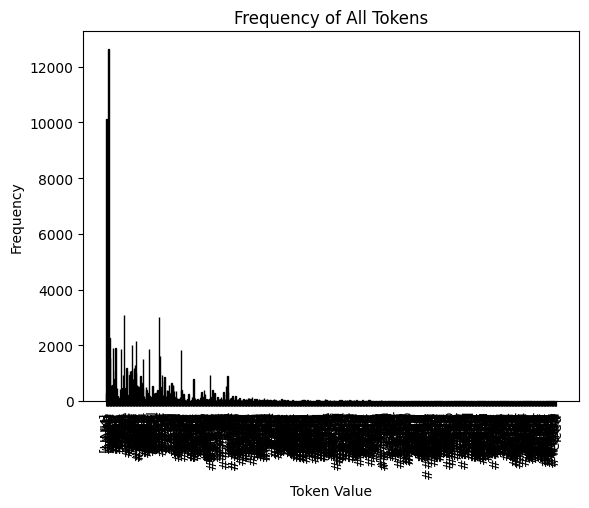

In [200]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming `all_tokens` is an array of tokens
# Count the frequency of tokens
token_counts = Counter(all_tokens)

# Separate tokens and their frequencies
tokens, frequencies = zip(*token_counts.items())  # Get all tokens and their frequencies

# Plot the histogram for all tokens
plt.bar(tokens, frequencies, edgecolor='black')
plt.title('Frequency of All Tokens')
plt.xlabel('Token Value')
plt.ylabel('Frequency')

# Rotate x-axis labels to vertical
plt.xticks(rotation=90)

# Show the plot
plt.show()

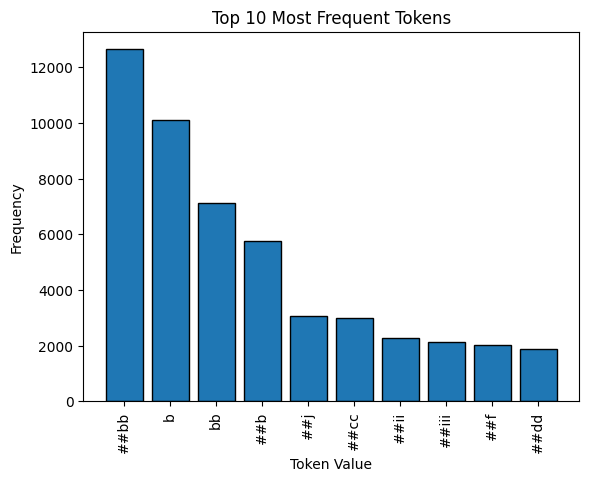

In [199]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming `all_tokens` is a list of lists of tokens
# Count the frequency of tokens across all sublists
token_counts = Counter(all_tokens)

# Get the top 10 most common tokens
top_10 = token_counts.most_common(10)
tokens, frequencies = zip(*top_10)  # Separate tokens and their frequencies

# Plot the histogram for the top 10 tokens
plt.bar(tokens, frequencies, edgecolor='black')
plt.title('Top 10 Most Frequent Tokens')
plt.xlabel('Token Value')
plt.ylabel('Frequency')

# Rotate x-axis labels to vertical
plt.xticks(rotation=90)

# Show the plot
plt.show()

visualize

In [172]:
print('\nLabel distribution (# windows)')
print(pd.Series(Y).value_counts())


Label distribution (# windows)
sit-stand    8900
sleep        7200
vehicle      3033
walking      1875
mixed        1651
Name: count, dtype: int64


/var/folders/mp/ptb2pg712ng_26w4_dsknfkw0000gr/T/ipykernel_97223/1471450867.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


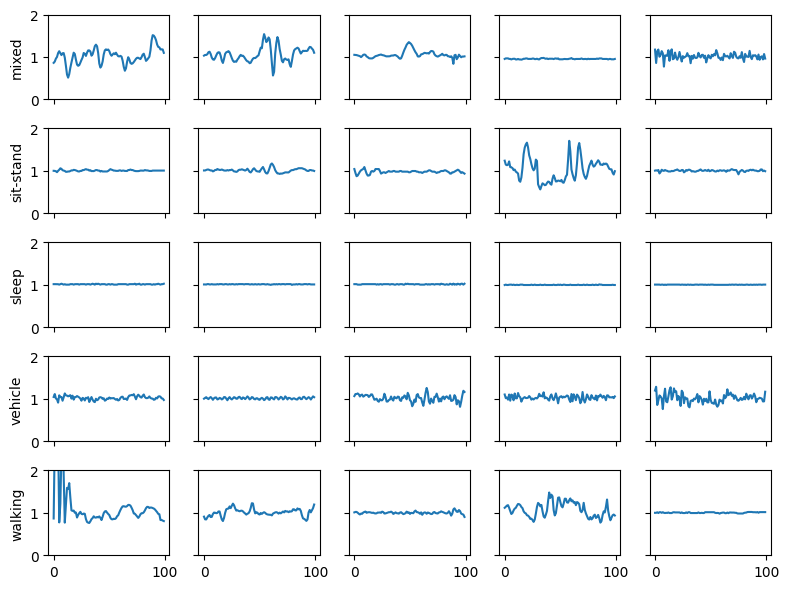

In [ ]:
np.random.seed(234)
NPLOTS = 5
unqY = np.unique(Y)
fig, axs = plt.subplots(len(unqY), NPLOTS, sharex=True, sharey=True, figsize=(8,6))
for y, row in zip(unqY, axs):
    idxs = np.random.choice(np.where(Y==y)[0], size=NPLOTS)
    row[0].set_ylabel(y)
    for x, ax in zip(X[idxs], row):
        ax.plot(np.linalg.norm(x[:1000], axis=-1))
        ax.set_ylim(0,2)
fig.tight_layout()
fig.show()

In [217]:
#each X is just for one participant
print(X)

[[[-0.06076062  0.5243622   0.8840633 ]
  [-0.06076062  0.5243622   0.8840633 ]
  [-0.06076062  0.5243622   0.8840633 ]
  ...
  [-0.06076062  0.5243622   0.86874497]
  [-0.06076062  0.5243622   0.86874497]
  [-0.06076062  0.5243622   0.86874497]]

 [[-0.06076062  0.5243622   0.86874497]
  [-0.06076062  0.5243622   0.86874497]
  [-0.06076062  0.5243622   0.8840633 ]
  ...
  [-0.06076062  0.5243622   0.86874497]
  [-0.06076062  0.5243622   0.86874497]
  [-0.06076062  0.5243622   0.86874497]]

 [[-0.06076062  0.5243622   0.86874497]
  [-0.06076062  0.5243622   0.86874497]
  [-0.06076062  0.5243622   0.86874497]
  ...
  [-0.06076062  0.5243622   0.86874497]
  [-0.06076062  0.5243622   0.86874497]
  [-0.06076062  0.5243622   0.86874497]]

 ...

 [[ 0.4459566   0.37573725  0.517273  ]
  [ 0.5688602   0.39123416  0.4253631 ]
  [ 0.63031197  0.37573725  0.39472646]
  ...
  [-0.35291693 -0.5385788   0.8389576 ]
  [-0.33755398 -0.5385788   0.8236393 ]
  [-0.30682805 -0.5540757   0.808321  ]]

 [

In [216]:
print(wearable_tokenizer(X))

['[UNK]', 'b', 'bb', '##bb', '##bb', 'b', 'b', 'b', 'b', 'b', '##dd', '##bb', '##b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'bb', 'b', 'b', 'bb', '##b', 'b', 'bb', 'bb', 'bb', 'bb', '##bb', 'bb', '##b', 'bb', 'bb', 'b', 'bb', '##bb', 'bb', 'b', 'b', 'bb', 'b', 'bb', 'bb', 'bb', '##bb', '##b', 'b', 'bb', 'bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', 'bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', 'bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', '##bb', 'bb', '##bb', 'b', 'b', 'b', 'bb', 'b', 'b', 'b',

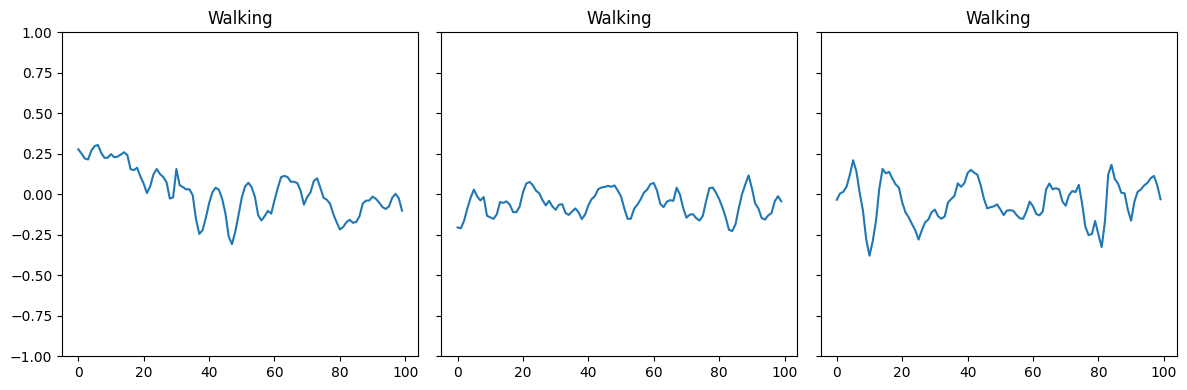

In [206]:
NPLOTS = 3

# Filter for Y == 'walking'
walking_idxs = np.where(Y == 'walking')[0]

# Select the first 3 indices for 'walking'
selected_idxs = walking_idxs[:NPLOTS]

# Plot the selected data
fig, axs = plt.subplots(1, NPLOTS, sharex=True, sharey=True, figsize=(12, 4))
for x, ax in zip(X[selected_idxs], axs):
    # Subtract 1 from the norm values
    ax.plot(np.linalg.norm(x[:1000], axis=-1) - 1)
    ax.set_ylim(-1, 1)  # Adjust y-limits to reflect the subtraction
    ax.set_title('Walking')

fig.tight_layout()
plt.show()

In [212]:
# Assuming `normalized_data` is already computed
min_value = np.min(normalized_data)
max_value = np.max(normalized_data)

print(f"Range of normalized_data: Min = {min_value}, Max = {max_value}")

# Assuming `normalized_data` is already computed
q1 = np.percentile(normalized_data, 25)  # 25th percentile (Q1)
q3 = np.percentile(normalized_data, 75)  # 75th percentile (Q3)
iqr = q3 - q1  # Interquartile range

print(f"Interquartile Range of normalized_data: Q1 = {q1}, Q3 = {q3}, IQR = {iqr}")

Range of normalized_data: Min = -0.9755313992500305, Max = 9.929889678955078
Interquartile Range of normalized_data: Q1 = -0.011807769536972046, Q3 = 0.021196603775024414, IQR = 0.03300437331199646


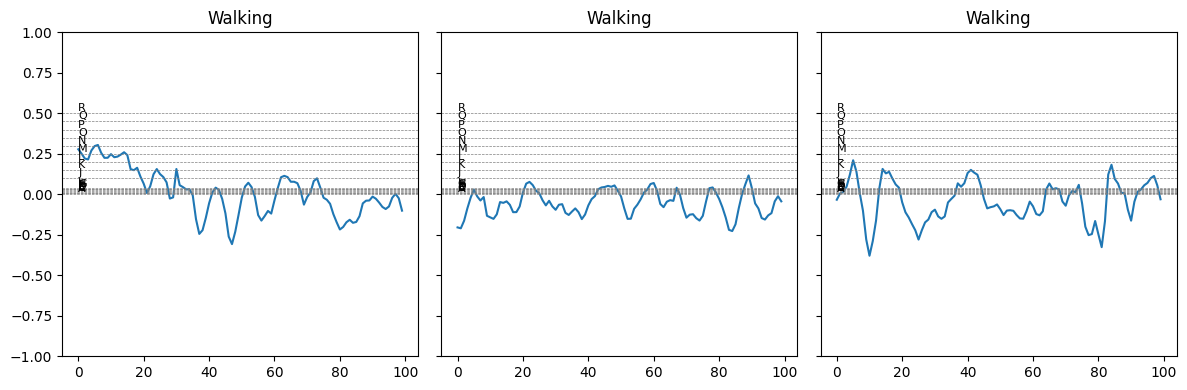

In [210]:
NPLOTS = 3

# Filter for Y == 'walking'
walking_idxs = np.where(Y == 'walking')[0]

# Select the first 3 indices for 'walking'
selected_idxs = walking_idxs[:NPLOTS]

# Define cut points and labels
cuts = np.array([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
labs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R']

# Plot the selected data
fig, axs = plt.subplots(1, NPLOTS, sharex=True, sharey=True, figsize=(12, 4))
for x, ax in zip(X[selected_idxs], axs):
    # Subtract 1 from the norm values
    norm_values = np.linalg.norm(x[:1000], axis=-1) -1
    ax.plot(norm_values)
    ax.set_ylim(-1, 1)  # Adjust y-limits to reflect the subtraction
    
    # Add cut lines and labels
    for cut, label in zip(cuts, labs):
        ax.axhline(y=cut , color='gray', linestyle='--', linewidth=0.5)  # Subtract 1 to align with normalized data
        ax.text(x=0, y=cut , s=label, color='black', fontsize=8, verticalalignment='bottom')

    ax.set_title('Walking')

fig.tight_layout()
plt.show()

compare walking between participants

array([[[-0.06076062,  0.5243622 ,  0.8840633 ],
        [-0.06076062,  0.5243622 ,  0.8840633 ],
        [-0.06076062,  0.5243622 ,  0.8840633 ],
        ...,
        [-0.06076062,  0.5243622 ,  0.86874497],
        [-0.06076062,  0.5243622 ,  0.86874497],
        [-0.06076062,  0.5243622 ,  0.86874497]],

       [[-0.06076062,  0.5243622 ,  0.86874497],
        [-0.06076062,  0.5243622 ,  0.86874497],
        [-0.06076062,  0.5243622 ,  0.8840633 ],
        ...,
        [-0.06076062,  0.5243622 ,  0.86874497],
        [-0.06076062,  0.5243622 ,  0.86874497],
        [-0.06076062,  0.5243622 ,  0.86874497]],

       [[-0.06076062,  0.5243622 ,  0.86874497],
        [-0.06076062,  0.5243622 ,  0.86874497],
        [-0.06076062,  0.5243622 ,  0.86874497],
        ...,
        [-0.06076062,  0.5243622 ,  0.86874497],
        [-0.06076062,  0.5243622 ,  0.86874497],
        [-0.06076062,  0.5243622 ,  0.86874497]],

       ...,

       [[ 0.4459566 ,  0.37573725,  0.517273  ],
        [ 0

In [198]:
tokens_w_id

,id,tokens
0,P001,"[[UNK], b, [UNK], [UNK], [UNK], [UNK], b, b, b, b, b, b, b, b, b, b, bb, b, b, bb, b, bb, bb, b, b, bb, ##b, bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, [UNK], bb, b, b, b, b, b, b, b, b, b, b, bb, b, bb, ##b, bb, bb, ##bb, ##bb, ##bb, ##b, bb, ##bb, ##b, b, b, bb, bb, ##b, b, b, bb, ##bb, ##bb, bb, ##b, b, b, bb, bb, ##bb, bb, ##bb, ##bb, ##bb, ##b, b, bb, ##b, bb, ##b, bb, ##b, bb, ##b, bb, bb, ##bb, ##b, b, bb, ##bb, ...]"
1,P002,"[[UNK], bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, bb, ##b, b, bb, ##bb, bb, bb, ##bb, bb, ##bb, ##bb, ##b, bb, ##bb, ##bb, ##bb, b, bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##b, b, b, bb, ##bb, b, b, bb, b, b, b, b, b, bb, ##b, b, b, b, bb, b, b, bb, b, b, b, b, b, b, [UNK], bb, ##b, bb, bb, b, bb, b, b, bb, bb, bb, bb, b, bb, ##bb, ##bb, ##bb, ##bb, bb, bb, b, b, b, b, b, b, b, b, b, b, bb, b, b, b, b, b, b, b, ...]"
2,P003,"[b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, bb, bb, b, bb, ##bb, b, b, bb, b, b, b, b, b, b, bb, b, b, bb, b, b, b, bb, bb, b, bb, bb, b, b, bb, b, b, b, bb, b, b, b, b, b, bb, b, b, b, b, b, b, b, b, b, bb, bb, b, b, b, b, bb, b, b, b, bb, b, b, bb, bb, bb, bb, bb, bb, b, ...]"
3,P004,"[bc, i, ##hi, b, bb, bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, bb, [UNK], bb, ##b, bb, ##b, bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##b, bb, ##b, bb, ##b, bb, ##b, bb, ##b, bb, ##bb, ##bb, bb, ##bb, ##bb, ##bb, ##bb, ##b, bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, bb, bb, ##b, bb, ...]"
4,P005,"[[UNK], c, [UNK], [UNK], bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##b, bb, ##bb, ##bb, ##bb, ##bb, ##b, bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, [UNK], bb, ##bb, ##b, [UNK], ff, ##c, [UNK], [UNK], e, ##fi, ##eb, d, ##gi, ##b, ##g, eh, ##db, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##b, bb, ##bb, ##bb, ##bb, ##bb, ##bb, bb, ##bb, ...]"
5,P006,"[d, ##f, b, bb, ##b, b, b, bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##b, bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##b, bb, ##b, bb, ##bb, ##bb, ##bb, ##b, bb, ##bb, ##bb, ##bb, ##bb, bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ...]"
6,P007,"[e, ee, bb, ##ec, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, dc, b, bb, b, b, b, b, bb, ##b, bb, b, bb, bb, bb, b, b, bb, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, e, ##g, e, ##b, bi, bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##b, bb, ##bb, ##bb, bb, ##b, bb, bb, bb, bb, ##b, b, b, bb, bb, ##b, b, b, b, bb, b, b, b, gb, ##b, b, b, b, b, bb, b, b, b, b, b, b, ...]"
7,P008,"[[UNK], bb, b, bb, ##bb, b, b, b, b, b, bb, b, bb, ##bb, ##bb, ##bb, ##bb, ##b, bb, ##bb, bb, ##b, bb, ##bb, ##b, bb, ##bb, bb, ##bb, ##bb, ##bb, bb, ##b, bb, ##bb, bb, ##bb, ##b, bb, ##bb, bb, ##bb, ##bb, ##bb, bb, ##bb, ##bb, ##bb, ##bb, ##bb, ##b, b, b, b, b, b, g, ##cci, ##ii, ##hi, ##iii, ##mi, ##ife, id, ##ih, ##ji, ##ij, ##bc, bf, ##c, iii, ##iii, ##ii, ##f, gb, ##c, ##fi, ##iii, ##ie, ##iii, ##ee, ##bc, ##cc, ##fc, ##c, g, ##c, ci, d, ##fe, b, b, bb, b, b, b, b, b, b, b, ...]"
8,P009,"[[UNK], b, bb, ##bb, ##bb, b, b, b, b, b, ##dd, ##bb, ##b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, b, bb, b, b, bb, ##b, b, bb, bb, bb, bb,

In [ ]:
#participant 

#similarity between walking for the same participant


#similarity between walking for different participant




